In [1]:
import sys 

%cd ../../
%pwd

from util import utils
from util import evaluation

In [2]:
models = ['gpt-j-6b', 'llama-3-8b', 'mamba-1.4b']
datasets = ['mcf']

path = '/mnt/scratch/stealth_edits/results/jetpack/'

In [3]:
def extract_jetpack_results(num_sample):

    template = 'jetpack_results_n{}_{}_{}_layer{}.pickle'

    values_to_save = ['edit_success_rate', 'fpr_wiki', 'fpr_other', 'probs_wiki', 'probs_other', 'ppl_op_other', 'crosstalk_count', 'mean_fpr_other', 'std_fpr_other', 'mean_fpr_wiki', 'std_fpr_wiki']

    jet_metrics = {}

    for dataset_name in datasets:

        model_metrics = {}

        for model_name in models:

            layers = evaluation.model_layer_indices[model_name]
            layer_metrics = {key:[] for key in values_to_save}

            for l in layers:
                try:
                    contents = utils.loadpickle(
                        os.path.join(path, template.format(
                            num_sample,
                            dataset_name,
                            model_name,
                            l
                        ))
                    )
                    layer_metrics['edit_success_rate'].append(contents['edit_success_rate'])
                    layer_metrics['crosstalk_count'].append(contents['crosstalk_count']/num_sample)
                    layer_metrics['fpr_wiki'].append(contents['fpr_wiki'])
                    # layer_metrics['fpr_other'].append(contents['fpr_other'])
                    layer_metrics['fpr_other'].append(contents['fpr_all_other'])

                    layer_metrics['probs_wiki'].append(contents['probs_wiki'][0])
                    # layer_metrics['probs_other'].append(contents['probs_other'][0])
                    layer_metrics['probs_other'].append(contents['probs_other_all'][0])

                    layer_metrics['ppl_op_other'].append(utils.smart_mean(contents['am_perplexity']/contents['om_perplexity']))

                    # mean_fpr_other, std_fpr_other = utils.smart_mean_std(contents['editwise_fpr_other'])
                    mean_fpr_other, std_fpr_other = utils.smart_mean_std(contents['editwise_fpr_all_other'])
                    layer_metrics['mean_fpr_other'].append(mean_fpr_other)
                    layer_metrics['std_fpr_other'].append(std_fpr_other)

                    mean_fpr_wiki, std_fpr_wiki = utils.smart_mean_std(contents['editwise_fpr_wiki'])
                    layer_metrics['mean_fpr_wiki'].append(mean_fpr_wiki)
                    layer_metrics['std_fpr_wiki'].append(std_fpr_wiki)

                except Exception as e:
                    print('P:', e)
                    for k in layer_metrics:
                        layer_metrics[k].append(np.nan)

            model_metrics[model_name] = copy.deepcopy(layer_metrics)

        jet_metrics[dataset_name] = copy.deepcopy(model_metrics)
    return copy.deepcopy(jet_metrics)

In [4]:
jet_metrics1000 = extract_jetpack_results(num_sample=1000)
jet_metrics4000 = extract_jetpack_results(num_sample=4000)

P: [Errno 2] No such file or directory: '/mnt/scratch/stealth_edits/results/jetpack/jetpack_results_n1000_mcf_llama-3-8b_layer1.pickle'
P: [Errno 2] No such file or directory: '/mnt/scratch/stealth_edits/results/jetpack/jetpack_results_n1000_mcf_llama-3-8b_layer5.pickle'
P: [Errno 2] No such file or directory: '/mnt/scratch/stealth_edits/results/jetpack/jetpack_results_n4000_mcf_llama-3-8b_layer1.pickle'
P: [Errno 2] No such file or directory: '/mnt/scratch/stealth_edits/results/jetpack/jetpack_results_n4000_mcf_llama-3-8b_layer5.pickle'
P: [Errno 2] No such file or directory: '/mnt/scratch/stealth_edits/results/jetpack/jetpack_results_n4000_mcf_mamba-1.4b_layer21.pickle'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


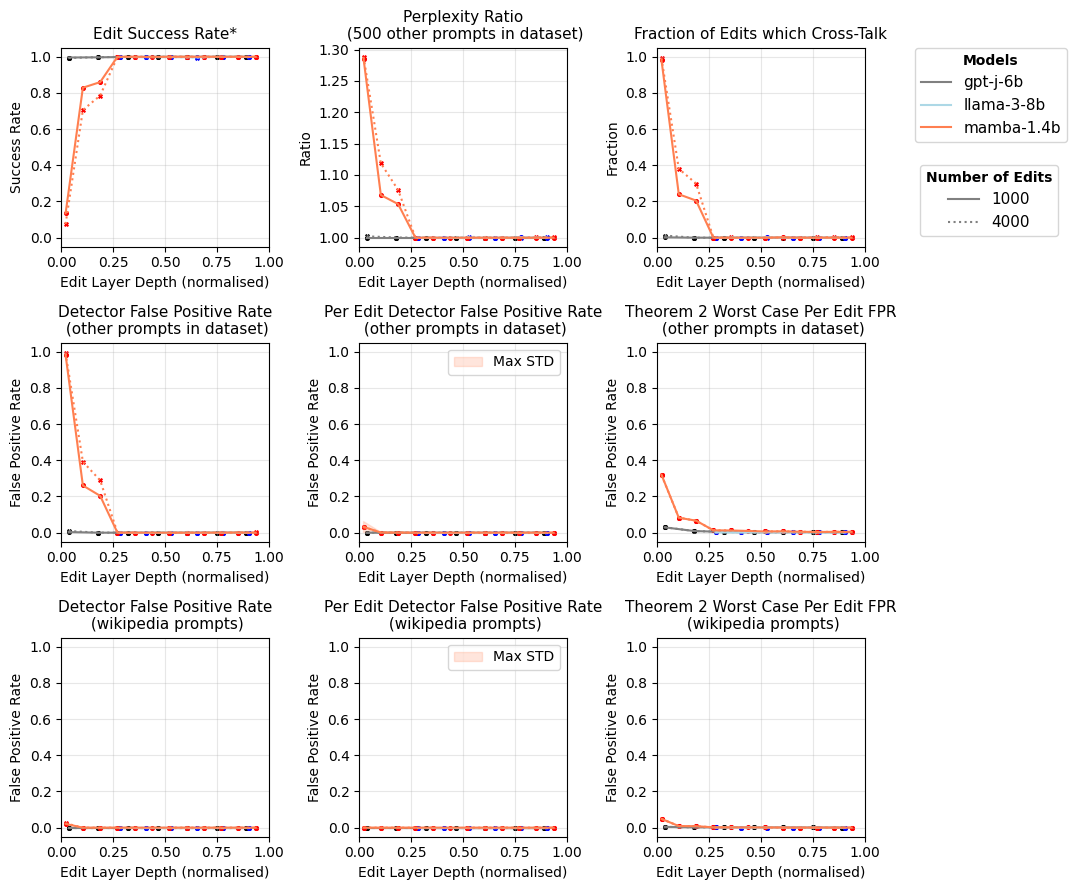

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))

main_colors = ['black', 'b', 'red']
sub_colors = ['gray', 'lightblue', 'coral']


model_handles = []
samplesize_handles = []

for i, model_name in enumerate(models):

    relative_depth = evaluation.model_layer_indices[model_name] \
        / evaluation.model_depth[model_name]

    axs[0,0].scatter(relative_depth, jet_metrics1000['mcf'][model_name]['edit_success_rate'], color=main_colors[i], s=7)
    axs[0,0].plot(relative_depth, jet_metrics1000['mcf'][model_name]['edit_success_rate'], color=sub_colors[i])

    axs[0,0].scatter(relative_depth, jet_metrics4000['mcf'][model_name]['edit_success_rate'], color=main_colors[i], s=7, marker='x')
    axs[0,0].plot(relative_depth, jet_metrics4000['mcf'][model_name]['edit_success_rate'], color=sub_colors[i], linestyle='dotted')

    axs[0,0].set_xlabel('Edit Layer Depth (normalised)')
    axs[0,0].set_ylabel('Success Rate')
    axs[0,0].set_title('Edit Success Rate*', fontsize=11)
    axs[0,0].set_xlim([0,1])
    axs[0,0].set_ylim([-0.05,1.05])

    axs[0,1].scatter(relative_depth, jet_metrics1000['mcf'][model_name]['ppl_op_other'], color=main_colors[i], s=7)
    axs[0,1].plot(relative_depth, jet_metrics1000['mcf'][model_name]['ppl_op_other'], color=sub_colors[i])

    axs[0,1].scatter(relative_depth, jet_metrics4000['mcf'][model_name]['ppl_op_other'], color=main_colors[i], s=7, marker='x')
    axs[0,1].plot(relative_depth, jet_metrics4000['mcf'][model_name]['ppl_op_other'], color=sub_colors[i], linestyle='dotted')


    axs[0,1].set_xlabel('Edit Layer Depth (normalised)')
    axs[0,1].set_ylabel('Ratio')
    axs[0,1].set_title('Perplexity Ratio\n (500 other prompts in dataset)', fontsize=11)
    axs[0,1].set_xlim([0,1])

    axs[0,2].scatter(relative_depth, jet_metrics1000['mcf'][model_name]['crosstalk_count'], color=main_colors[i], s=7)
    axs[0,2].plot(relative_depth, jet_metrics1000['mcf'][model_name]['crosstalk_count'], color=sub_colors[i])

    axs[0,2].scatter(relative_depth, jet_metrics4000['mcf'][model_name]['crosstalk_count'], color=main_colors[i], s=7, marker='x')
    axs[0,2].plot(relative_depth, jet_metrics4000['mcf'][model_name]['crosstalk_count'], color=sub_colors[i], linestyle='dotted')

    axs[0,2].set_xlabel('Edit Layer Depth (normalised)')
    axs[0,2].set_ylabel('Fraction')
    axs[0,2].set_title('Fraction of Edits which Cross-Talk', fontsize=11)
    axs[0,2].set_xlim([0,1])
    axs[0,2].set_ylim([-0.05,1.05])


    axs[1,0].scatter(relative_depth, jet_metrics1000['mcf'][model_name]['fpr_other'], color=main_colors[i], s=7)
    axs[1,0].plot(relative_depth, jet_metrics1000['mcf'][model_name]['fpr_other'], color=sub_colors[i])

    axs[1,0].scatter(relative_depth, jet_metrics4000['mcf'][model_name]['fpr_other'], color=main_colors[i], s=7, marker='x')
    axs[1,0].plot(relative_depth, jet_metrics4000['mcf'][model_name]['fpr_other'], color=sub_colors[i], linestyle='dotted')

    axs[1,0].set_xlabel('Edit Layer Depth (normalised)')
    axs[1,0].set_ylabel('False Positive Rate')
    axs[1,0].set_title('Detector False Positive Rate\n (other prompts in dataset)', fontsize=11)
    axs[1,0].set_xlim([0,1])
    axs[1,0].set_ylim([-0.05,1.05])

    if i == 2:
        label_to_insert = 'Max STD'
    else:
        label_to_insert = None
    
    mean_fpr_other1000 = jet_metrics1000['mcf'][model_name]['mean_fpr_other']
    std_fpr_other1000 = jet_metrics1000['mcf'][model_name]['std_fpr_other']
    mean_fpr_other4000 = jet_metrics4000['mcf'][model_name]['mean_fpr_other']
    std_fpr_other4000 = jet_metrics4000['mcf'][model_name]['std_fpr_other']

    max_mean = np.maximum(mean_fpr_other1000, mean_fpr_other4000)
    min_mean = np.minimum(mean_fpr_other1000, mean_fpr_other4000)
    max_std = np.maximum(std_fpr_other1000, std_fpr_other4000)

    axs[1,1].scatter(relative_depth, mean_fpr_other1000, color=main_colors[i], s=7)
    axs[1,1].plot(relative_depth, mean_fpr_other1000, color=sub_colors[i])

    axs[1,1].scatter(relative_depth, mean_fpr_other4000, color=main_colors[i], s=7, marker='x')
    axs[1,1].plot(relative_depth, mean_fpr_other4000, color=sub_colors[i], linestyle='dotted')
    axs[1,1].fill_between(relative_depth, (min_mean-max_std), (max_mean+max_std), color=sub_colors[i], alpha=0.2, label=label_to_insert)
    axs[1,1].set_xlim([0,1])
    axs[1,1].set_ylim([-0.05,1.05])
    axs[1,1].set_xlabel('Edit Layer Depth (normalised)')
    axs[1,1].set_ylabel('False Positive Rate')
    axs[1,1].set_title('Per Edit Detector False Positive Rate\n (other prompts in dataset)', fontsize=11)
    axs[1,1].legend()

    axs[1,2].scatter(relative_depth, jet_metrics1000['mcf'][model_name]['probs_other'], color=main_colors[i], s=7)
    axs[1,2].plot(relative_depth, jet_metrics1000['mcf'][model_name]['probs_other'], color=sub_colors[i])

    axs[1,2].scatter(relative_depth, jet_metrics4000['mcf'][model_name]['probs_other'], color=main_colors[i], s=7, marker='x')
    axs[1,2].plot(relative_depth, jet_metrics4000['mcf'][model_name]['probs_other'], color=sub_colors[i], linestyle='dotted')

    axs[1,2].set_xlabel('Edit Layer Depth (normalised)')
    axs[1,2].set_ylabel('False Positive Rate')
    axs[1,2].set_title('Theorem 2 Worst Case Per Edit FPR\n (other prompts in dataset)', fontsize=11)
    axs[1,2].set_xlim([0,1])
    axs[1,2].set_ylim([-0.05,1.05])


    axs[2,0].scatter(relative_depth, jet_metrics1000['mcf'][model_name]['fpr_wiki'], color=main_colors[i], s=7)
    axs[2,0].plot(relative_depth, jet_metrics1000['mcf'][model_name]['fpr_wiki'], color=sub_colors[i])

    axs[2,0].scatter(relative_depth, jet_metrics4000['mcf'][model_name]['fpr_wiki'], color=main_colors[i], s=7, marker='x')
    axs[2,0].plot(relative_depth, jet_metrics4000['mcf'][model_name]['fpr_wiki'], color=sub_colors[i], linestyle='dotted')

    axs[2,0].set_xlabel('Edit Layer Depth (normalised)')
    axs[2,0].set_ylabel('False Positive Rate')
    axs[2,0].set_title('Detector False Positive Rate\n (wikipedia prompts)', fontsize=11)
    axs[2,0].set_xlim([0,1])
    axs[2,0].set_ylim([-0.05,1.05])


    mean_fpr_wiki1000 = jet_metrics1000['mcf'][model_name]['mean_fpr_wiki']
    std_fpr_wiki1000 = jet_metrics1000['mcf'][model_name]['std_fpr_wiki']
    mean_fpr_wiki4000 = jet_metrics4000['mcf'][model_name]['mean_fpr_wiki']
    std_fpr_wiki4000 = jet_metrics4000['mcf'][model_name]['std_fpr_wiki']

    max_mean = np.maximum(mean_fpr_wiki1000, mean_fpr_wiki4000)
    min_mean = np.minimum(mean_fpr_wiki1000, mean_fpr_wiki4000)
    max_std = np.maximum(std_fpr_wiki1000, std_fpr_wiki4000)

    axs[2,1].scatter(relative_depth, mean_fpr_wiki1000, color=main_colors[i], s=7)
    axs[2,1].plot(relative_depth, mean_fpr_wiki1000, color=sub_colors[i])

    axs[2,1].scatter(relative_depth, mean_fpr_wiki4000, color=main_colors[i], s=7, marker='x')
    axs[2,1].plot(relative_depth, mean_fpr_wiki4000, color=sub_colors[i], linestyle='dotted')
    axs[2,1].fill_between(relative_depth, (min_mean-max_std), (max_mean+max_std), color=sub_colors[i], alpha=0.2, label=label_to_insert)
    axs[2,1].set_xlim([0,1])
    axs[2,1].set_ylim([-0.05,1.05])
    axs[2,1].set_xlabel('Edit Layer Depth (normalised)')
    axs[2,1].set_ylabel('False Positive Rate')
    axs[2,1].set_title('Per Edit Detector False Positive Rate\n (wikipedia prompts)', fontsize=11)
    axs[2,1].legend()


    axs[2,2].scatter(relative_depth, jet_metrics1000['mcf'][model_name]['probs_wiki'], color=main_colors[i], s=7)
    mh = axs[2,2].plot(relative_depth, jet_metrics1000['mcf'][model_name]['probs_wiki'], color=sub_colors[i], label=model_name)
    model_handles.append(mh[0])

    axs[2,2].scatter(relative_depth, jet_metrics4000['mcf'][model_name]['probs_wiki'], color=main_colors[i], s=7, marker='x')
    axs[2,2].plot(relative_depth, jet_metrics4000['mcf'][model_name]['probs_wiki'], color=sub_colors[i], label=model_name, linestyle='dotted')

    axs[2,2].set_xlabel('Edit Layer Depth (normalised)')
    axs[2,2].set_ylabel('False Positive Rate')
    axs[2,2].set_title('Theorem 2 Worst Case Per Edit FPR\n (wikipedia prompts)', fontsize=11)
    axs[2,2].set_xlim([0,1])
    axs[2,2].set_ylim([-0.05,1.05])

    if i == 0:
        dh0 = axs[2,0].plot(relative_depth, jet_metrics1000['mcf'][model_name]['fpr_wiki'], color=sub_colors[i], label='1000')
        dh1 = axs[2,0].plot(relative_depth, jet_metrics4000['mcf'][model_name]['fpr_wiki'], color=sub_colors[i], linestyle='dotted', label='4000')
        samplesize_handles.append(dh0[0])
        samplesize_handles.append(dh1[0])


for i in range(3):
    for j in range(3):
        axs[i,j].grid(True, alpha=0.3)


model_legend = fig.legend(model_handles, ['gpt-j-6b', 'llama-3-8b', 'mamba-1.4b'], bbox_to_anchor=(1.2, 0.95), loc = 'upper right', title='Models', title_fontproperties={'weight':'bold'}, fontsize=11)
samplesize_legend = fig.legend(samplesize_handles, ['1000', '4000'], bbox_to_anchor=(1.19, 0.82), loc = 'upper right', title='Number of Edits', title_fontproperties={'weight':'bold'}, fontsize=11)

plt.tight_layout()
plt.savefig('jetpacks9.png', dpi=300, bbox_inches='tight')
plt.show()